# Working with Chinook

The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store. The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

db = "/Users/judy/Documents/chinook.db"

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    q = """
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");"""
    
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Selecting Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. Choose the albums based on the popularity of genres.

In [5]:
q_genre_rank = """
    WITH 
        track_sales_usa AS
        (SELECT
            t.genre_id,
            t.name track_name,
            c.country
        FROM customer c
        INNER JOIN invoice i ON i.customer_id = c.customer_id
        INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
        INNER JOIN track t ON il.track_id = t.track_id
        WHERE c.country = 'USA'
        )
        
    SELECT
        g.name genre_type,
        COUNT(tsu.track_name) number_of_tracks,
        CAST(COUNT(tsu.track_name) as Float)/CAST((SELECT COUNT(track_name) FROM track_sales_usa) as Float) percentage_of_tracks
    FROM track_sales_usa tsu
    INNER JOIN genre g ON tsu.genre_id = g.genre_id
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 10;"""

run_query(q_genre_rank)

,genre_type,number_of_tracks,percentage_of_tracks
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


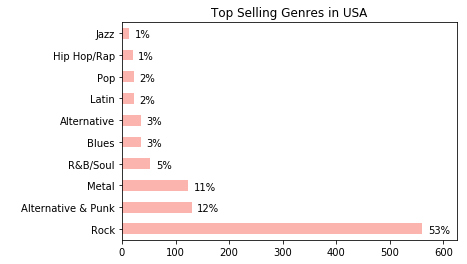

In [9]:
usa_genre_rank = run_query(q_genre_rank)
usa_genre_rank.set_index("genre_type", drop=True, inplace=True)

usa_genre_rank["number_of_tracks"].plot.barh(
    title="Top Selling Genres in USA",
    xlim=(0, 625),
    colormap="Pastel1")

plt.ylabel(" ")

for i, label in enumerate(list(usa_genre_rank.index)):
    score = usa_genre_rank.loc[label, "number_of_tracks"]
    label = (usa_genre_rank.loc[label, "percentage_of_tracks"]*100).astype(int).astype(str) + "%" 
    plt.annotate(str(label), (score + 10, i - 0.2))

plt.show()

From the above table, we should choose the most popular genre which is 'Rock', accounting for more than a half of tracks. The second is 'Alternative & Punk' and the third is 'Metal'.

# Analyzing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

You might like to consider whether any extra columns from the employee table explain any variance you see, or whether the variance might instead be indicative of employee performance.

In [14]:
c_employee_sales = """
    CREATE VIEW customer_total AS
        SELECT 
            c.customer_id,
            c.first_name || " " || c.last_name customer_name,
            c.support_rep_id,
            SUM(i.total) total
        FROM customer c
        INNER JOIN invoice i ON i.customer_id = c.customer_id
        GROUP BY 1;"""

run_command(c_employee_sales)

q_employee_sales = """
    SELECT 
        e.employee_id,
        e.first_name || " " || e.last_name employee_name,
        e.hire_date,
        COUNT(ct.customer_id) total_customers,
        SUM(ct.total) total_sales
    FROM employee e 
    INNER JOIN customer_total ct ON e.employee_id = ct.support_rep_id
    GROUP BY 1
    """

run_query(q_employee_sales)

,employee_id,employee_name,hire_date,total_customers,total_sales
0,3,Jane Peacock,2017-04-01 00:00:00,21,1731.51
1,4,Margaret Park,2017-05-03 00:00:00,20,1584.00
2,5,Steve Johnson,2017-10-17 00:00:00,18,1393.92


In [3]:
#為調整VIEW用
c_drop = """
DROP VIEW itm;"""

run_command(c_drop)

# Analyzing Sales by Country

Your next task is to analyze the sales data for customers from each different country. Because there are a number of countries with only one customer, you should group these customers as "Other" in your analysis. 

In [15]:
#Reference Answer
sales_by_country = """
WITH country_or_other AS
    (
    SELECT
      CASE
          WHEN (
                SELECT count(*)
                FROM customer 
                WHERE country = c.country
                ) = 1 THEN "Other"
          ELSE c.country
      END AS country,
      c.customer_id,
      il.*
    FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    )
    
SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT 
        country,
        COUNT(DISTINCT customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / COUNT(DISTINCT customer_id) customer_lifetime_value,
        SUM(unit_price) / COUNT(DISTINCT invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
"""

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


# Visualizing Sales by Country

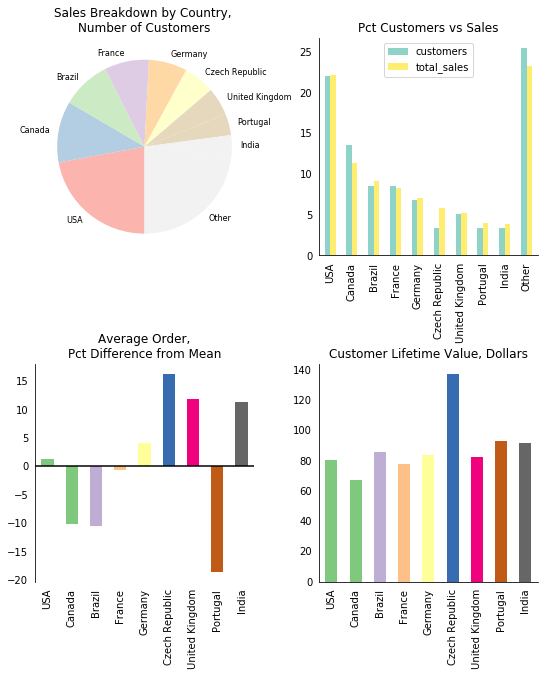

In [24]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

#top left
sales_breakdown = country_metrics["total_sales"].copy().rename("")
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title="Sales Breakdown by Country, \nNumber of Customers",
    colormap=plt.cm.Pastel1,
    fontsize=8,
    wedgeprops={"linewidth":0}
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set3,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

# Albums vs Individual Tracks

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In [25]:
#Reference Answer
album_vs_track = """
WITH 
    invoice_first_track AS
        (
        SELECT 
            il.invoice_id,
            MIN(il.track_id) first_track_id
        FROM invoice_line il
        GROUP BY 1
        ),
    album_purchase AS
        (
        SELECT
            ifs.*,
            CASE 
                WHEN
                    (SELECT t.track_id FROM track t
                     WHERE album_id = (
                                       SELECT album_id FROM track t2 
                                       WHERE t2.track_id = ifs.first_track_id
                                       )
                                       
                     EXCEPT
                     
                     SELECT il2.track_id FROM invoice_line il2
                     WHERE il2.invoice_id = ifs.invoice_id
                     ) IS NULL
                AND
                    (
                     SELECT il2.track_id FROM invoice_line il2
                     WHERE il2.invoice_id = ifs.invoice_id
                     
                     EXCEPT
                     
                     SELECT t.track_id FROM track t
                     WHERE album_id = (
                                       SELECT album_id FROM track t2
                                       WHERE t2.track_id = ifs.first_track_id                                                                                                                      
                                      )
                    ) IS NULL
                THEN "yes"
                ELSE "no"
            END AS "album_purchase"
        FROM invoice_first_track ifs
        )
    
SELECT 
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(COUNT(invoice_id) AS Float) / (SELECT COUNT(*) FROM invoice) percent
FROM album_purchase
GROUP BY album_purchase;
"""

run_query(album_vs_track)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


# Which artist is used in the most playlists?

In [32]:
q_most_artist = """
SELECT
    artist_id,
    name artist_name,
    COUNT(*) appear_playlist_times
FROM 
    (
    SELECT 
        pt.playlist_id,
        ar.name,
        t.track_id,
        t.album_id,
        a.artist_id
    FROM playlist_track pt
    LEFT JOIN track t ON t.track_id = pt.track_id
    LEFT JOIN album a ON t.album_id = a.album_id
    INNER JOIN artist ar ON a.artist_id = ar.artist_id
    ) playlist_artist
GROUP BY artist_id
ORDER BY 3 DESC
LIMIT 10
;"""

run_query(q_most_artist)

,artist_id,artist_name,appear_playlist_times
0,90,Iron Maiden,516
1,150,U2,333
2,50,Metallica,296
3,22,Led Zeppelin,252
4,58,Deep Purple,226
5,149,Lost,184
6,118,Pearl Jam,177
7,81,Eric Clapton,145
8,82,Faith No More,145
9,100,Lenny Kravitz,143


# How many tracks have been purchased vs not purchased?

In [8]:
c_being_purchased = """
CREATE VIEW being_purchased AS
SELECT
    a.album_id,
    a.title album_name,
    COUNT(DISTINCT il.track_id) tracks_being_purchased
FROM invoice_line il
LEFT JOIN track t ON t.track_id = il.track_id
LEFT JOIN album a ON a.album_id = t.album_id
GROUP BY 1
;"""

run_command(c_being_purchased)

In [9]:
q_album_sales = """
SELECT
    at.*,
    CASE 
        WHEN (bp.tracks_being_purchased IS NULL) THEN 0
        ELSE bp.tracks_being_purchased
    END AS purchased_tracks
FROM album_track at
LEFT JOIN being_purchased bp ON at.album_id = bp.album_id
LIMIT 20;"""

run_query(q_album_sales)

,album_id,album_name,all_tracks_number,purchased_tracks
0,1,For Those About To Rock We Salute You,10,10
1,2,Balls to the Wall,1,1
2,3,Restless and Wild,3,3
3,4,Let There Be Rock,8,8
4,5,Big Ones,15,15
5,6,Jagged Little Pill,13,13
6,7,Facelift,12,12
7,8,Warner 25 Anos,14,14
8,9,Plays Metallica By Four Cellos,8,8
9,10,Audioslave,14,14


# Is the range of tracks in the store reflective of their sales popularity?

In [39]:
q_total_vs_purchased = """
WITH 
    genre_purchased AS
        (
         SELECT 
            g.name genre_type,
            COUNT(il.track_id) purchased_times
         FROM invoice_line il
         LEFT JOIN track t ON t.track_id = il.track_id
         LEFT JOIN genre g ON g.genre_id = t.genre_id
         GROUP BY 1),
     genre_track AS
         (
          SELECT
              g.genre_id,
              g.name genre_type,
              COUNT(t.track_id) total_tracks
          FROM track t
          INNER JOIN genre g ON t.genre_id = g.genre_id
          GROUP BY 1)

SELECT 
    gt.genre_id,
    gt.genre_type,
    gt.total_tracks,
    CASE 
        WHEN (gp.purchased_times IS NULL) THEN 0
        ELSE gp.purchased_times
    END AS purchased_times
FROM genre_track gt
LEFT JOIN genre_purchased gp on gt.genre_type = gp.genre_type
;"""

run_query(q_total_vs_purchased)

,genre_id,genre_type,total_tracks,purchased_times
0,1,Rock,1297,2635
1,2,Jazz,130,121
2,3,Metal,374,619
3,4,Alternative & Punk,332,492
4,5,Rock And Roll,12,0
5,6,Blues,81,124
6,7,Latin,579,167
7,8,Reggae,58,35
8,9,Pop,48,63
9,10,Soundtrack,43,5


# Do protected and non-protected media types have an effect on popularity?

In [40]:
q_rock_protected = """
WITH 
    rock_track_sales AS
        (
         SELECT
             m.media_type_id,
             m.name media_name,
             COUNT(DISTINCT il.track_id) purchased_track_total
         FROM invoice_line il
         INNER JOIN track t ON t.track_id = il.track_id
         INNER JOIN media_type m ON m.media_type_id = t.media_type_id
         INNER JOIN genre g ON g.genre_id = t.genre_id
         WHERE g.name = 'Rock'
         GROUP BY 1
         ),
    rock_media_tracks AS
        (
         SELECT 
             m.media_type_id,
             COUNT(t.track_id) track_total
         FROM track t 
         INNER JOIN media_type m ON m.media_type_id = t.media_type_id
         INNER JOIN genre g ON g.genre_id = t.genre_id
         WHERE g.name = 'Rock'
         GROUP BY 1
         )
         
SELECT 
    CASE 
        WHEN media_name LIKE "%Protected%" THEN "Protected"
        ELSE "Non-Protected"
    END AS protected_or_not,
    SUM(rts.purchased_track_total) purchased_track_total,
    SUM(rmt.track_total) track_total
FROM rock_track_sales rts
INNER JOIN rock_media_tracks rmt ON rmt.media_type_id = rts.media_type_id
GROUP BY 1
;"""

run_query(q_rock_protected)

,protected_or_not,purchased_track_total,track_total
0,Non-Protected,847,1213
1,Protected,68,84


In [43]:
rock_sales = run_query(q_rock_protected)
rock_sales["dead_track_stock"] = rock_sales["track_total"] - rock_sales["purchased_track_total"]
rock_sales = rock_sales[["protected_or_not","purchased_track_total", "dead_track_stock", "track_total"]]

rock_add_total = ["Total"]
for i in rock_sales.columns[1:]:
    total = rock_sales[i].sum()
    rock_add_total.append(total)
rock_sales.loc[2] = rock_add_total
rock_sales

,protected_or_not,purchased_track_total,dead_track_stock,track_total
0,Non-Protected,847,366,1213
1,Protected,68,16,84
2,Total,915,382,1297


In [46]:
from scipy.stats import chisquare 

rock_obs = np.array([847, 366, 68, 16])
rock_exp = np.array([1213*915/1297, 1213*382/1297, 84*915/1297, 84*382/1297])
rock_chisquare, rock_pvalue = chisquare(rock_obs, rock_exp)
rock_chisquare

4.67988419697835

卡方檢定：在95％信心水準下，檢定值大於3.841（k=1），表示消費者對媒體類型有偏好，偏好不受保護的音樂類型。